In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.manifold import TSNE
data = pickle.load(open('ana.pkl','rb'))
data.keys()

dict_keys(['Xtest', 'Ytest', 'hidden_states', 'hidden_states_decay', 'emb'])

In [10]:
Ytest = np.array(data['Ytest'])
Xtest = np.array(data['Xtest'])
# Ytest = np.power(2,Ytest)
hs = np.array(data['hidden_states'])
len(Ytest),hs.shape
print(len(hs[0][0]), len(Xtest[0]))


12 12


# hidden_states

len graph 406339


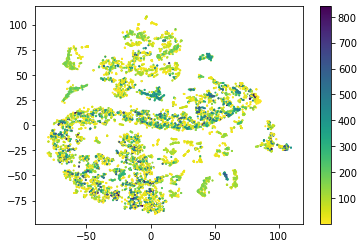

In [15]:
hs_embedding = np.array(data['hidden_states'])
graph_emb = []
graph_size = []
for batch in hs_embedding:
    for gs in batch:  # only one gs(include many cascade) per batch
        size = 0
        for c in gs:
            size+=1
            graph_emb.append(c)
            graph_size.append(size)
print("len graph {}".format(len(graph_emb)))
X = TSNE(n_components=2,random_state=42,learning_rate=50,n_iter=2000).fit_transform(graph_emb[:10000])
sc = plt.scatter(X[:, 0], X[:, 1], s=1, c=graph_size[:10000], cmap='viridis_r')
plt.colorbar(sc)
plt.show()


# hidden_states sum pooling

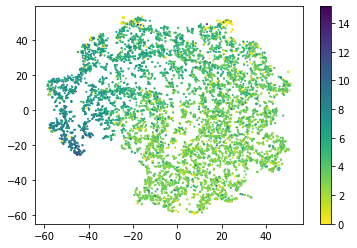

len graph 8886


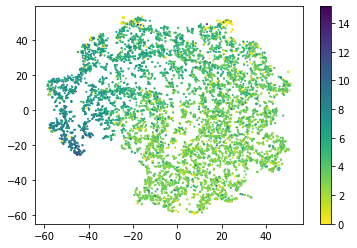

In [44]:
hs_embedding = np.array(data['hidden_states_decay'])
graph_emb = []
for cascade in hs_embedding:
    for g in cascade:
        size = 0
        emb = 0
        for e in g:
            size += 1
            emb+=e
    graph_emb.append(emb)
print("len graph {}".format(len(graph_emb)))
X = TSNE(n_components=2, random_state=42,
         learning_rate=50).fit_transform(graph_emb)
sc = plt.scatter(X[:, 0], X[:, 1], s=1, c=Ytest, cmap='viridis_r')
plt.colorbar(sc)
plt.show()


# hidden_states_decay

In [35]:
hs_embedding = data['hidden_states_decay']

graph_emb = []
graph_size = []
for cascade in hs_embedding:
    for g in cascade:
        size = 0
        for e in g:
            size+=1
            graph_emb.append(e)
            graph_size.append(size)
        
print("len graph {}".format(len(graph_emb)))
X = TSNE(n_components=2, random_state=42,
         learning_rate=50).fit_transform(graph_emb[:10000])
sc = plt.scatter(X[:, 0], X[:, 1], s=1, c=graph_size[:10000], cmap='viridis_r')
plt.colorbar(sc)
plt.show()


len graph 406339


# hawkes graph embeddings

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.manifold import TSNE

X_embedded = pickle.load(open('embeddings.pkl','rb'))[0]
# X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)
idmap = pickle.load(open('../../data/deephawkes/weibo-hawkes-100/idmap.pkl','rb'))
test_data = pickle.load(open('../../data/deephawkes/weibo-hawkes-100/data_test.pkl','rb'))[0]
len(idmap)


(752575, 50)


752575

In [2]:
len_arr = [(idx,len(x)) for idx,x in enumerate(test_data)]
max_num=0
for i in len_arr:
    if max_num<i[1]:
        id = i[0]
        max_num = i[1]
cascade_example = test_data[id]


In [3]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [5]:
def cascade_emb(cascade_example, interval=10, growth=False, max_pool=False):
    cascade_len = len(cascade_example)
    interval = int(cascade_len/interval)
    if interval == 0:
        interval = 1
    pad = 752574
    tmp_subgraph_embeding = []
    subgraph_embeding = []
    graph_size = []
    for i in range(interval, cascade_len+interval, interval):
        cascade = flatten_list(cascade_example[:i])
        cascade = set(cascade)
        cascade.remove(pad)
        cascade = list(cascade)
        graph_size.append(len(cascade))
        emb = np.zeros_like(X_embedded[0])
        for id in cascade:
            if max_pool:
                emb = np.maximum(emb, X_embedded[id])
            else:
                emb += X_embedded[id]
        tmp_subgraph_embeding.append(emb)
    if growth == True:
        tmp_graph_size = graph_size
        graph_size = []
        for i in range(1, len(tmp_subgraph_embeding)):
            emb = tmp_subgraph_embeding[i]-tmp_subgraph_embeding[i-1]
            size = tmp_graph_size[i]-tmp_graph_size[i-1]
            subgraph_embeding.append(emb)
            graph_size.append(size)
    else:
        subgraph_embeding = tmp_subgraph_embeding
    return subgraph_embeding, graph_size

In [6]:
subgraph_embeding = []
graph_size = []
for cascade_example in test_data:
    emb,size = cascade_emb(cascade_example,max_pool=True)
    subgraph_embeding+=emb
    graph_size += size
len(subgraph_embeding)
len(graph_size)

85712

# avg graph(node sum) feature emb

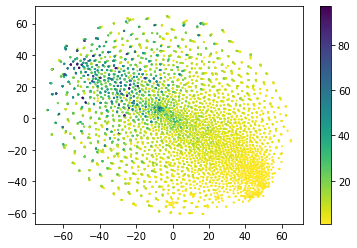

In [8]:
X = TSNE(n_components=2,random_state=42,learning_rate=50).fit_transform(subgraph_embeding[:10000])
sc = plt.scatter(X[:, 0], X[:, 1], s=1, c=graph_size[:10000], cmap='viridis_r')
plt.colorbar(sc)
plt.show()


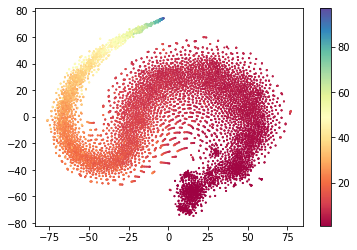

In [12]:
subgraph_embeding = []
graph_size = []
for cascade_example in test_data:
    emb,size = cascade_emb(cascade_example)
    subgraph_embeding+=emb
    graph_size += size
X = TSNE(n_components=2,random_state=42,learning_rate=50).fit_transform(subgraph_embeding[:10000])
sc = plt.scatter(X[:, 0], X[:, 1],s=1, c=graph_size[:10000], cmap=plt.cm.Spectral)
plt.colorbar(sc)
plt.show()

In [13]:
growth_subgraph_embeding = []
growth_graph_size = []
for cascade_example in test_data:
    emb,size = cascade_emb(cascade_example,growth=True)
    growth_subgraph_embeding+=emb
    growth_graph_size += size

# graph emb (growth)

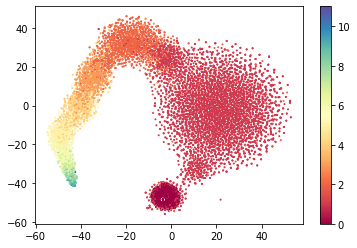

In [14]:
growth_X = TSNE(n_components=2,random_state=42,learning_rate=50).fit_transform(growth_subgraph_embeding[:10000])
sc = plt.scatter(growth_X[:, 0], growth_X[:, 1],s=1, c=growth_graph_size[:10000], cmap=plt.cm.Spectral)
plt.colorbar(sc)
plt.show()

# random emb(before train)

In [ ]:
X_embedded = np.random.standard_normal(size=(752575,50))
random_subgraph_embeding = []
random_graph_size = []
for cascade_example in test_data:
    emb,size = cascade_emb(cascade_example)
    random_subgraph_embeding+=emb
    random_graph_size += size


random_X = TSNE(n_components=2,random_state=42,learning_rate=50).fit_transform(random_subgraph_embeding[:10000])
sc = plt.scatter(random_X[:, 0], random_X[:, 1],s=1, c=random_graph_size[:10000], cmap=plt.cm.Spectral)
plt.colorbar(sc)
plt.show()

In [ ]:
X_embedded = np.ones((752575,50))*0.1
random_subgraph_embeding = []
random_graph_size = []
for cascade_example in test_data:
    emb,size = cascade_emb(cascade_example)
    random_subgraph_embeding+=emb
    random_graph_size += size
random_X = TSNE(n_components=2,random_state=42,learning_rate=50).fit_transform(random_subgraph_embeding[:10000])
sc = plt.scatter(random_X[:, 0], random_X[:, 1],s=1, c=random_graph_size[:10000], cmap=plt.cm.Spectral)
plt.colorbar(sc)
plt.show()
